In [1]:
from typing import Sequence, Optional, Dict

import clingo.ast
from clingo import PropagateInit, PropagateControl
from clingo.ast import ProgramBuilder
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
import numpy as np
import descartes

In [2]:
db = {
    "square1": Polygon([(0, 0), (2, 0), (2, 2), (0, 2)]),
    "square2": Polygon([(1, 1), (3, 1), (3, 3), (1, 3)]),
}
db

{'square1': <shapely.geometry.polygon.Polygon at 0x7fd6f8cdb6a0>,
 'square2': <shapely.geometry.polygon.Polygon at 0x7fd796723640>}

In [3]:
data = """
type(polygon).

product(polygon, "square1").
product(polygon, "square2").
"""

In [4]:
program = """
&intersect{ "square1"; "square2" } = intersect(polygon, "intersect_1_2").
&union{ "square1"; "square2" } = union(polygon, "union_1_2").
"""

In [5]:
theory = """
#theory spatial {
	constant  {};
	spatial_term {};
	&union/0 : spatial_term, {=}, constant, any;
	&intersect/0 : spatial_term, {=}, constant, any
}.
"""

In [6]:
def unwrap(theory_term: clingo.TheoryTerm):
    if theory_term.type is clingo.TheoryTermType.Symbol:
        return theory_term.name[1:-1]
    elif theory_term.type is clingo.TheoryTermType.Number:
        return theory_term.number
    elif theory_term.type is clingo.TheoryTermType.Function:
        return str(theory_term)
    arguments = (unwrap(argument) for argument in theory_term.arguments)
    if theory_term.type is clingo.TheoryTermType.Set:
        return set(arguments)
    elif theory_term.type is clingo.TheoryTermType.Tuple:
        return tuple(arguments)
    elif theory_term.type is clingo.TheoryTermType.List:
        return list(arguments)
    else:
        assert False, "Unknown TheoryTermType {} of TheoryTerm {}.".format(theory_term.type, theory_term)

In [7]:
class SpatialTransformer(clingo.ast.Transformer):
    pass

In [8]:
class SpatialPropagator(clingo.Propagator):

    def __init__(self, database: Optional[Dict[str, Polygon]] = None):
        self._l2t = {}  # literal -> (op, geoms, assign)
        self._a2l = {}  # assign -> literal
        self._l2s = {}  # literal -> solver_literal
        self._s2l = {}  # solver_literal -> literal
        self._qrst = QRST(database)

    def init(self, init: PropagateInit) -> None:
        for atom in init.theory_atoms:
            term = atom.term
            op = term.name
            geoms = sorted(unwrap(element.terms[0]) for element in atom.elements)
            assign = unwrap(atom.guard[1])
            program_literal = atom.literal
            solver_literal = init.solver_literal(program_literal)
            self._l2t[program_literal] = (op, geoms, assign)
            self._l2s[program_literal] = solver_literal
            self._s2l[solver_literal] = program_literal
            self._a2l[assign] = program_literal
            init.add_watch(solver_literal)
            if init.assignment.is_true(solver_literal):
                self.propagate_assignment(op, geoms, assign)

    def propagate(self, control: PropagateControl, changes: Sequence[int]) -> None:
        for change in changes:
            if change in self._s2l:
                program_literal = self._s2l[change]
                op,geoms,assign = self._l2t[program_literal]
                self.propagate_assignment(op, geoms, assign)

    def propagate_assignment(self, op, geoms, assign):
        self._qrst.evaluate(op, geoms, assign)





In [9]:

class QRST:

    def __init__(self, database: Optional[Dict[str, Polygon]] = None):
        self._db: Dict[str, Polygon] = database or {}
        self._assignments: Dict[str, str] = {}

    def evaluate(self, operation: str, geoms: str, assign: str) -> None:
        geom_id: str = "{}({})".format(operation, ','.join(sorted(geoms)))
        if geom_id not in self._db:
            if operation == 'intersect':
                self.intersect(geom_id, geoms)
            elif operation == 'union':
                self.union(geom_id, geoms)

        self._assignments[assign] = geom_id

    def intersect(self, geom_id: str, geoms: Sequence[str]) -> None:
        polys = list(self._db[geom] for geom in geoms)
        new_poly = polys[0]
        i = 1
        while i < len(polys):
            new_poly = new_poly.intersection(polys[i])
            i += 1
        self._db[geom_id] = new_poly

    def union(self, geom_id: str, geoms: Sequence[str]) -> None:
        polys = list(self._db[geom] for geom in geoms)
        new_poly = polys[0]
        i = 1
        while i < len(polys):
            new_poly = new_poly.union(polys[i])
            i += 1
        self._db[geom_id] = new_poly



In [10]:
ctl = clingo.Control()
ctl.configuration.solve.models = 0

In [11]:
propagator = SpatialPropagator(db)
transformer = SpatialTransformer()

In [12]:
ctl.register_propagator(propagator)

In [13]:
ctl.add('base', [], theory)
print(theory)
ctl.add('base', [], data)
print(data)
stmts = []
clingo.ast.parse_string(program, lambda stm: stmts.append(transformer.visit(stm)))
with ProgramBuilder(ctl) as builder:
    for stm in stmts:
        print(stm)
        builder.add(stm)


#theory spatial {
	constant  {};
	spatial_term {};
	&union/0 : spatial_term, {=}, constant, any;
	&intersect/0 : spatial_term, {=}, constant, any
}.


type(polygon).

product(polygon, "square1").
product(polygon, "square2").

#program base.
&intersect { "square1"; "square2" } = intersect(polygon,"intersect_1_2").
&union { "square1"; "square2" } = union(polygon,"union_1_2").


In [14]:
ctl.ground([('base', ())])

In [15]:
with ctl.solve(yield_=True) as solve_handle:
    models = []
    for model in solve_handle:
        symbols = sorted(model.symbols(shown=True, theory=True))
        models.append(model)
        print("Answer {}:".format(model.number), end=' ')
        print("{",
              '\n'.join(map(str, symbols)), "}", sep='\n')
    solve_result = solve_handle.get()
    print(solve_result, end='')
    if models:
        print(" {}{}".format(len(models), '' if solve_result.exhausted else '+'))

Answer 1: {
type(polygon)
product(polygon,"square1")
product(polygon,"square2")
}
SAT 1


In [16]:
print(propagator._l2t)

{4: ('union', ['square1', 'square2'], 'union(polygon,"union_1_2")'), 5: ('intersect', ['square1', 'square2'], 'intersect(polygon,"intersect_1_2")')}


In [17]:
for geom_id, polygon in db.items():
    print("{}={}".format(geom_id, polygon))

square1=POLYGON ((0 0, 2 0, 2 2, 0 2, 0 0))
square2=POLYGON ((1 1, 3 1, 3 3, 1 3, 1 1))
union(square1,square2)=POLYGON ((2 0, 0 0, 0 2, 1 2, 1 3, 3 3, 3 1, 2 1, 2 0))
intersect(square1,square2)=POLYGON ((2 2, 2 1, 1 1, 1 2, 2 2))


/home/lukas/.local/share/miniconda/envs/asp-ideas/lib/python3.10/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


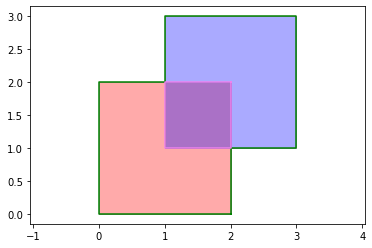

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.add_patch(descartes.PolygonPatch(db['square1'], fc='red', alpha=1/3))
ax.add_patch(descartes.PolygonPatch(db['square2'], fc='blue', alpha=1/3))
ax.plot(*db['union(square1,square2)'].exterior.xy, color='green')
ax.plot(*db['intersect(square1,square2)'].exterior.xy, color='violet')

ax.axis('equal')
plt.show()